In [5]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [6]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)

In [7]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1260, 78)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,sum_mel_spect,spikes_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,sum_chroma_stft,spikes_rms,mean_rms,max_rms,var_rms,std_rms,sum_rms,spikes_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,sum_spec_cent,spikes_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,sum_spec_bw,spikes_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,sum_spec_rolloff,spikes_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,sum_spec_cont,spikes_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1\s1_an_1,m,anger,0,1443,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,102124.031250,750,0.402497,0.097249,0.311847,710.004517,83,0.129479,0.340202,0.007750,0.088035,19.033358,58,1814.026368,812.639867,4084.492417,437557.880517,661.481580,266661.876085,69,1834.495092,1104.902824,2673.005407,154644.510964,393.248663,269670.778594,71,3811.157227,904.394531,6707.592773,2.016124e+06,1419.902686,560240.112305,344,22.718679,7.062807,51.588313,82.005473,9.055687,23377.521049,65,0.093647,0.026855,0.269531,0.001995,0.044666,13.766113,-171.056549,115.938042,-28.566433,21.314878,-26.507704,10.144446,-22.394417,-6.446075,-20.058737,-9.614691,-15.731797,-8.805967,-2.915169,-12.226694,-5.387331,-4.913489,-9.523164,-1.791623,-3.507744,0.083974
1,2\s1_an_2,m,anger,0,1297,4.795431,3.266728e-10,1598.459473,1602.659546,40.033230,74909.429688,578,0.369817,0.094729,0.307780,545.850342,64,0.122001,0.275363,0.007222,0.084985,15.006124,46,1813.929245,1077.773997,4802.078139,517671.206155,719.493715,223113.297102,46,1772.517500,1209.119846,2615.316302,160594.827485,400.742845,218019.652450,48,3602.609923,1711.889648,7288.989258,2.051509e+06,1432.308845,443121.020508,304,22.243432,5.936659,48.160193,77.321635,8.793272,19151.594977,42,0.095251,0.034668,0.402832,0.004444,0.066661,11.715820,-187.978119,114.721764,-41.258282,22.174334,-12.715221,11.881122,-22.636301,-9.284857,-23.113138,-7.031469,-15.980973,-11.601790,-5.727098,-6.378960,-7.155037,-7.385511,-8.306025,4.346861,-6.595266,-2.742662
1,3\s1_an_3,m,anger,0,1392,3.334237,3.032449e-10,689.850159,542.464478,23.290867,50390.328125,603,0.402758,0.097614,0.312432,575.137756,57,0.093039,0.258287,0.007551,0.086896,11.071583,61,1699.189320,1154.867212,2519.734104,118628.430190,344.424782,202203.529082,51,1764.541591,1131.241853,2699.423772,195473.567039,442.123927,209980.449275,57,3558.226103,1604.223633,5770.898438,1.733753e+06,1316.720683,423428.906250,301,21.846660,6.884981,48.784060,66.028699,8.125805,18198.267397,58,0.089708,0.041016,0.129395,0.000406,0.020160,10.675293,-241.878052,123.269180,-36.750164,15.108225,-17.863935,12.198894,-16.139629,-8.320073,-9.156641,-3.037857,-7.307014,-2.118013,-5.378597,-6.666719,-4.749491,-4.346241,-5.281549,3.802923,-7.263710,3.085279
1,4\s1_an_4,m,anger,0,898,7.300478,3.510179e-10,3062.532715,4610.922363,67.903770,98279.039062,417,0.272837,0.095383,0.308841,347.048981,58,0.155781,0.308454,0.007771,0.088151,16.512766,41,1578.663080,989.554541,3072.898800,113822.283518,337.375582,167338.286433,37,1679.770568,1277.610555,2577.918929,89344.835302,298.906064,178055.680195,39,3222.159447,1539.624023,6180.029297,9.498801e+05,974.617910,341548.901367,238,23.566948,8.367288,49.570257,78.338294,8.850892,17486.675197,44,0.068912,0.036621,0.134277,0.000354,0.018807,7.304688,-166.445877,122.271973,-42.199047,19.365204,-21.122906,8.933196,-21.792807,-10.018277,-22.990004,-9.038509,-19.050367,-9.762542,0.404813,-14.561901,-6.730536,-4.809193,-5.546733,2.948940,-6.117626,-3.003350
1,5\s1_an_5,m,anger,0,909,6.344573,4.247520e

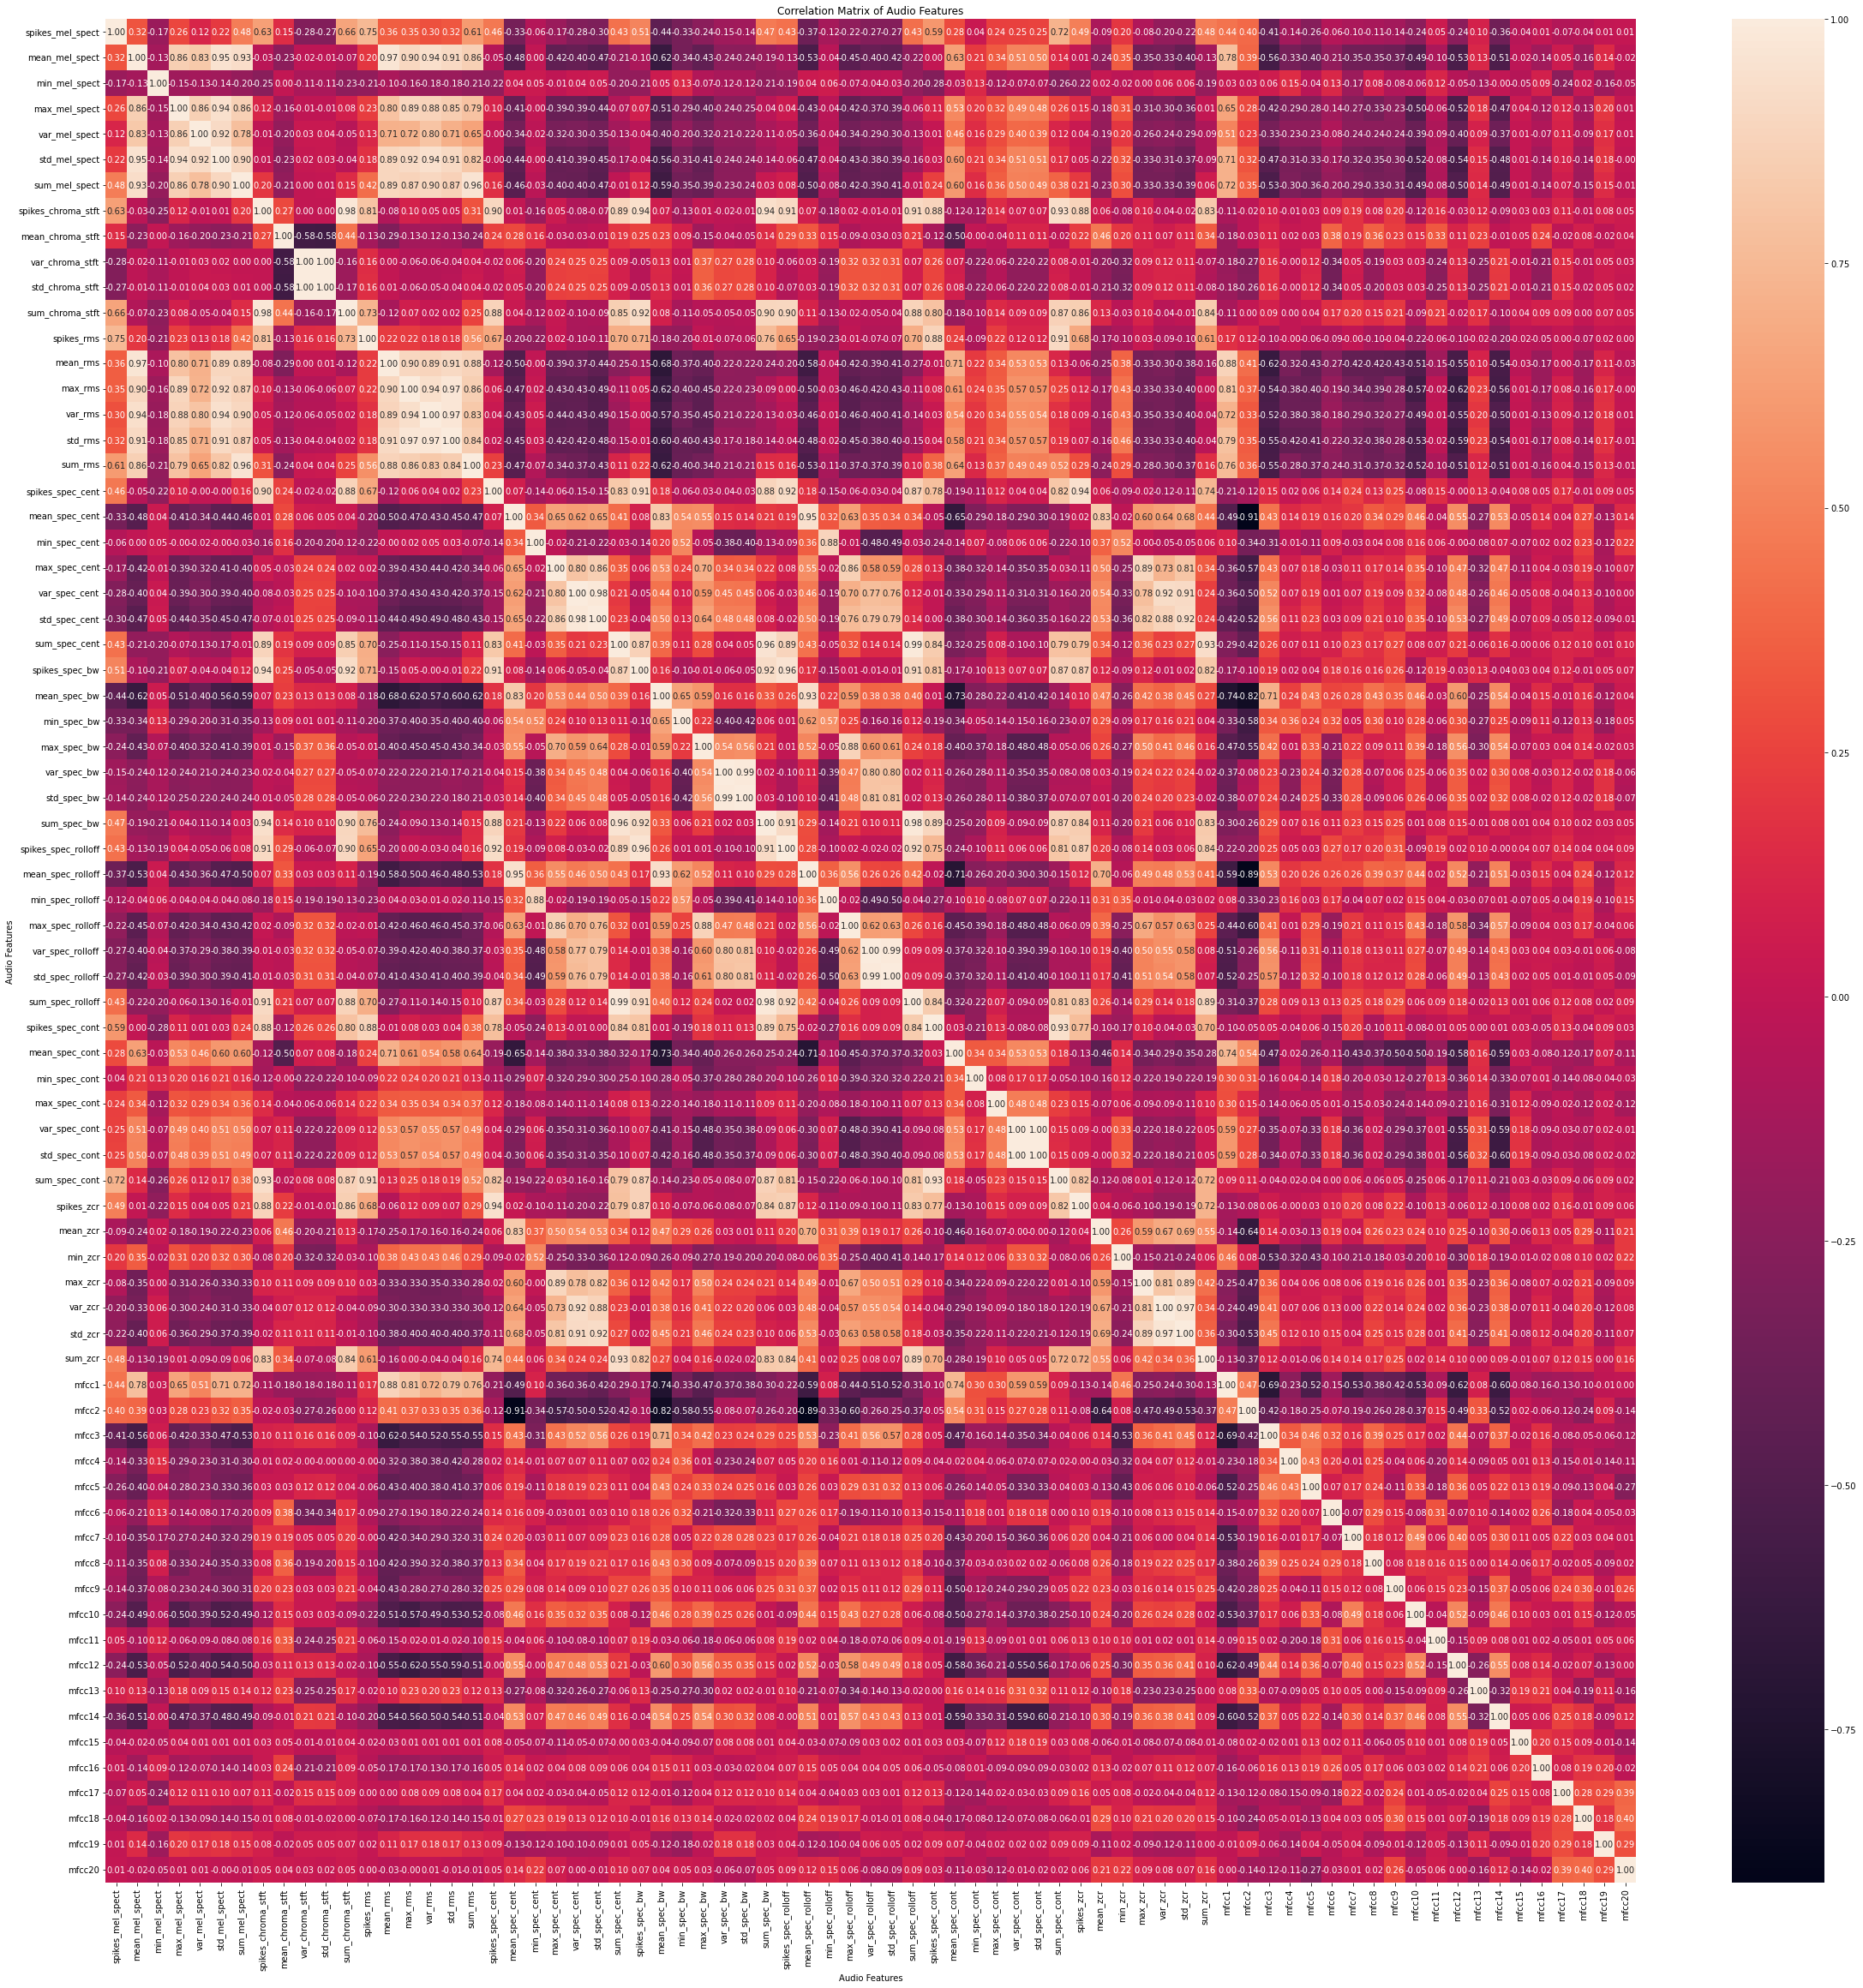

In [8]:
plt.figure(figsize=(40,40))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [9]:
def hight_corr_feat_elimination(df_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > 0.7\
            and ((pair[0][1], pair[0][0]), pair[1]) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), pair[1]))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > 0.7 and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [10]:
eliminated_feats = hight_corr_feat_elimination(df_corr)
print(len(eliminated_feats))
print(eliminated_feats)

37
{'var_chroma_stft', 'std_mel_spect', 'mean_spec_bw', 'spikes_spec_rolloff', 'spikes_zcr', 'var_rms', 'spikes_spec_cont', 'sum_spec_cont', 'mean_mel_spect', 'sum_zcr', 'var_spec_rolloff', 'var_spec_cont', 'mean_spec_cent', 'spikes_rms', 'std_spec_bw', 'mean_rms', 'min_spec_rolloff', 'std_spec_rolloff', 'sum_spec_rolloff', 'sum_chroma_stft', 'max_spec_rolloff', 'std_zcr', 'max_rms', 'sum_spec_bw', 'sum_mel_spect', 'std_rms', 'std_spec_cent', 'max_spec_cent', 'sum_rms', 'max_zcr', 'spikes_spec_bw', 'sum_spec_cent', 'var_spec_cent', 'max_mel_spect', 'mean_spec_rolloff', 'spikes_spec_cent', 'mfcc1'}


In [11]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")

Number of features after high correlation elimination: 36


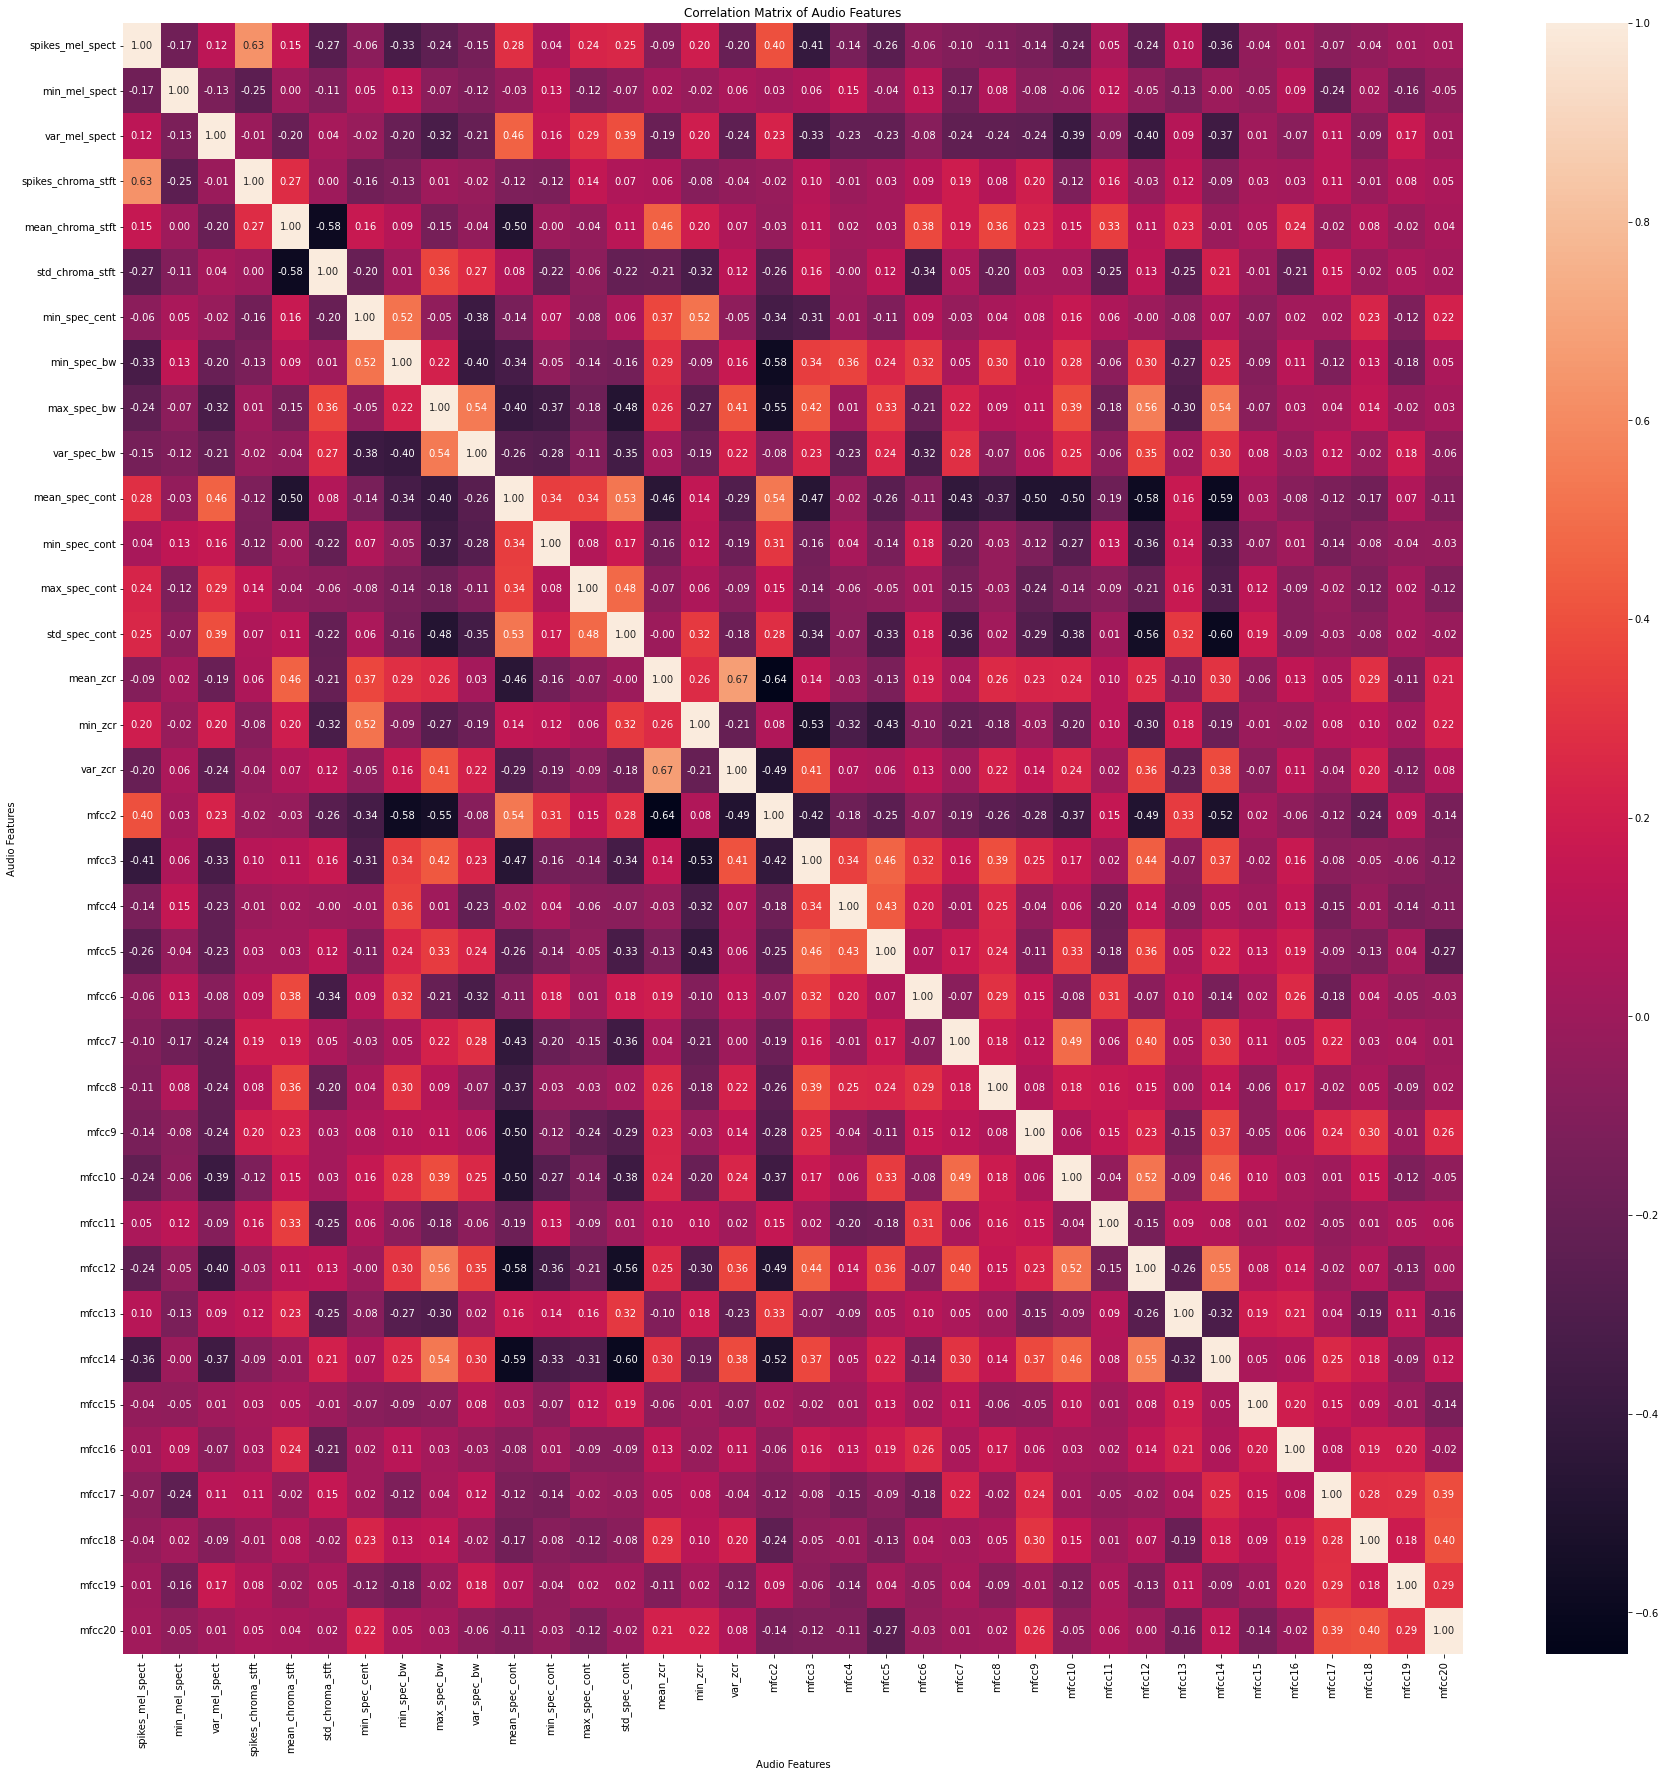

In [12]:
plt.figure(figsize=(30,30))
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [13]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

## Compare Scores of Classifiers

In [14]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        scores = cross_val_score(clf, data, labels, cv=5)
        
        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score)
    
    return clfs_scores

In [15]:
%%capture
clfs = [
    DecisionTree(random_state=1, max_features=None),
    ExtraTree(random_state=1, max_features=None),
    RandomForest(random_state=1, max_features=None),
    ExtraTrees(random_state=1, max_features=None),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [16]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

print(f"\nClassifiers Ordered by Lowest Standard Deviation Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][1])
    ), orient="index", columns=["Mean", "Std"]), headers = 'keys'
))

Classifiers Ordered by Highest Mean Accuracy:
                            Mean        Std
----------------------  --------  ---------
ExtraTreesClassifier    0.446825  0.0314069
RidgeClassifier         0.444444  0.0252226
RandomForestClassifier  0.43254   0.0400774
XGBClassifier           0.429365  0.0407322
DecisionTreeClassifier  0.301587  0.0160702
ExtraTreeClassifier     0.261111  0.0338955

Classifiers Ordered by Lowest Standard Deviation Accuracy:
                            Mean        Std
----------------------  --------  ---------
DecisionTreeClassifier  0.301587  0.0160702
RidgeClassifier         0.444444  0.0252226
ExtraTreesClassifier    0.446825  0.0314069
ExtraTreeClassifier     0.261111  0.0338955
RandomForestClassifier  0.43254   0.0400774
XGBClassifier           0.429365  0.0407322


In [17]:
clf = RandomForest(random_state=1, max_features=None)
clf.fit(data, labels)
importance = clf.feature_importances_
importance

array([0.05477731, 0.        , 0.05244079, 0.03532602, 0.02438127,
       0.02677858, 0.0198678 , 0.021431  , 0.02845103, 0.03211356,
       0.02073136, 0.02043691, 0.02320806, 0.023784  , 0.05588858,
       0.02528037, 0.0315102 , 0.02917004, 0.03519622, 0.03048952,
       0.0267707 , 0.03878129, 0.02994701, 0.02557405, 0.02455256,
       0.02229594, 0.03172774, 0.02232141, 0.03196897, 0.01660382,
       0.0254157 , 0.021131  , 0.02815721, 0.02041274, 0.02016814,
       0.0229091 ])

## Custom Feature Elimination with Propagation

In [18]:
def feature_elim(data, features, labels, n_features=1):
    data_c = data.copy()
    features = list(features)
    total_features = len(features)
    results = pd.DataFrame(columns=["Mean Acc", "Std Acc"])

    for _ in range(total_features-1, n_features-1, -1):
        acc = pd.DataFrame(columns=["Feature", "Mean Acc", "Std Acc"])
        
        for feat in tqdm(features):
            X_train = data_c.copy()

            X_train.drop(feat, inplace=True, axis=1)

            clf = RandomForest(random_state=1, max_features=None)
            scores = cross_val_score(clf, X_train, labels, cv=5)

            # mean score across all folds
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            acc.loc[feat] = [feat, mean_score, std_score]

        acc_scaled = acc.copy(deep=True)
        acc_scaled[acc_scaled.columns[1]] = minmax_scale(acc_scaled[acc_scaled.columns[1]], (0, 1))
        acc_scaled[acc_scaled.columns[2]] = minmax_scale(acc_scaled[acc_scaled.columns[2]], (0, 1))
        acc_scaled = acc_scaled.values.tolist()
        worse_feat = sorted(acc_scaled, key=lambda x: x[1]*0.5 - x[2]*0.5, reverse=True)[0]
        worse_feat = acc.loc[acc['Feature'] == worse_feat[0]].values[0]
        data_c.drop(worse_feat[0], inplace=True, axis=1)
        features.remove(worse_feat[0])
        results.loc[worse_feat[0]] = [worse_feat[1], worse_feat[2]]

    return results

In [19]:
custom_feat_elim_df = feature_elim(data, features, labels, 1)
custom_feat_elim_df.to_csv("custom_feat_elim.csv")
custom_feat_elim_df

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


,Mean Acc,Std Acc
spikes_mel_spect,0.434921,0.019375
mfcc20,0.445238,0.015754
min_spec_cent,0.446032,0.012944
mean_spec_cont,0.439683,0.006349
mfcc16,0.453968,0.011931
max_spec_cont,0.449206,0.008838
mfcc19,0.446032,0.007360
mfcc8,0.443651,0.009187
min_mel_spect,0.446032,0.009255
std_chroma_stft,0.442857,0.011391


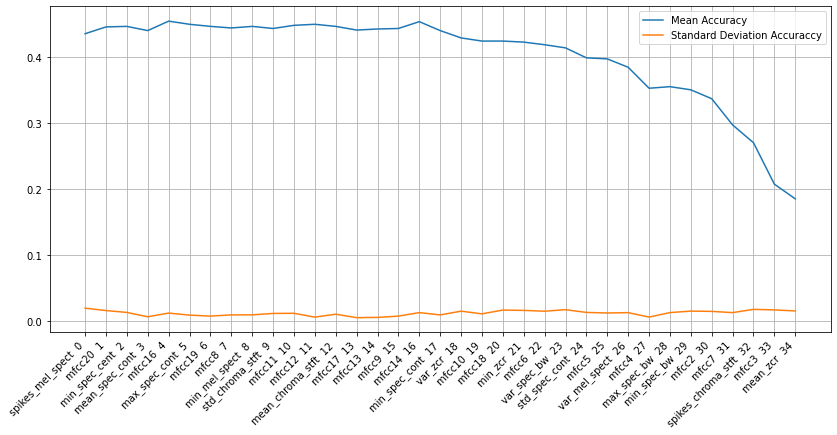

In [20]:
custom_feat_elim_df = pd.read_csv("custom_feat_elim.csv", index_col=0)
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
x_labels = [f"{custom_feat_elim_df.index.values[i]}  {i}" for i in range(len(custom_feat_elim_df.index.values))]
ax.plot(x_labels, custom_feat_elim_df['Mean Acc'].values, label="Mean Accuracy")
ax.plot(x_labels, custom_feat_elim_df['Std Acc'].values, label="Standard Deviation Accuraccy")
plt.legend()

In [21]:
def energy_method(df, energy_perc, column):
    total = np.sum(df[column].values)
    elim_feats = []

    cumulative_val = 0
    for feat, columns in df.iterrows():
        val = columns[column]
        cumulative_val += val
        elim_feats.append(feat)
        if (cumulative_val * 100 / total) >= energy_perc:
            break
    
    return elim_feats

custom_elim_feats = energy_method(custom_feat_elim_df, 80, "Mean Acc")

## Feature Elimination with Backward Propagation

- Less 1 feature

In [22]:
sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=num_features-1, forward=False, cv=5, n_jobs=8)
sfs1 = sfs1.fit(data, labels)
print(sfs1.k_score_)
feat_names = set(sfs1.k_feature_names_)
left_out_features = [feat for feat in features if feat not in feat_names]
print(left_out_features)

0.4428571428571429
['mfcc17']


- For All Features

In [23]:
feat_elim = {}
df_train = data.copy()
for i in range(num_features-1, 0, -1):
    sfs1 = sfs(RandomForest(random_state=1, max_features=None), k_features=i, forward=False, cv=5, n_jobs=8)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

In [24]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                 Accuracy
-------------  ----------
mfcc17           0.442857
min_spec_cont    0.440476
mfcc14           0.438095
min_spec_bw      0.440476
mfcc4            0.445238
mfcc2            0.453175
mfcc15           0.445238
mfcc19           0.446032
mfcc10           0.452381
mfcc11           0.448413


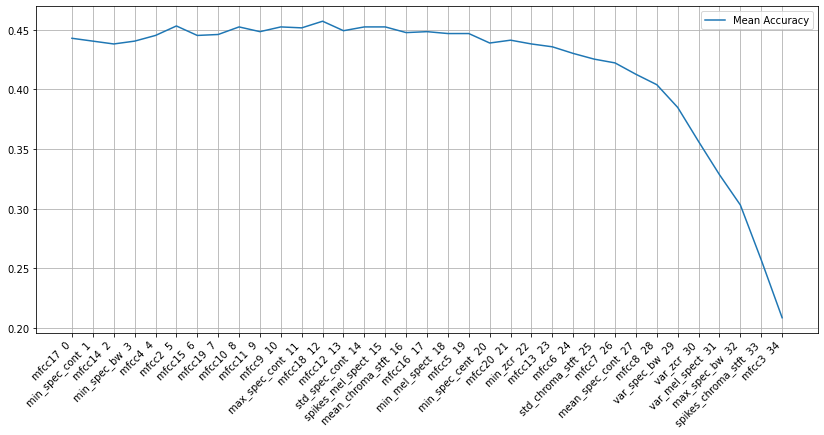

In [25]:
feat_elim_df = pd.read_csv("feat_elim.csv", index_col=0)
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
plt.legend()

In [26]:
elim_feats = energy_method(feat_elim_df, 80, "Accuracy")
common_elim_feats = [x for x in custom_elim_feats if x in elim_feats]
print('Feature Elimination with Propagation - Keeping 80% "Energy"\n')

print(f"Number of Eliminated Features Using:\n\t-Mean Accuracy as the Decider Metric: {len(elim_feats)}")
print(f"\t-Mean and Standard Deviation Accuracy as the Decider Metrics: {len(custom_elim_feats)}\n")
print(f"Common Eliminated Features betwen the two: {len(common_elim_feats)}")

Feature Elimination with Propagation - Keeping 80% "Energy"

Number of Eliminated Features Using:
	-Mean Accuracy as the Decider Metric: 27
	-Mean and Standard Deviation Accuracy as the Decider Metrics: 26

Common Eliminated Features betwen the two: 22


In [27]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in common_elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")

Number of Features After Eliminating Common Features: 14


## PCA

In [28]:
pca = PCA(random_state=1)
data_scaled = StandardScaler().fit_transform(data)
data_pca = pca.fit_transform(data_scaled)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var = {}
for i in range(1, len(explained_variance)+1):
    comp_var[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.192563
2,0.292823
3,0.375036
4,0.447788
5,0.497817
6,0.545869
7,0.592799
8,0.634408
9,0.667109
10,0.697015


In [29]:
min_var = .9
threshold = 0.01
prev_exp_var = 0
for num_component, total_exp_var in comp_var.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component

24

In [30]:
pca = PCA(random_state=1)
data_scaled_elim = StandardScaler().fit_transform(data_elim_feats)
data_pca_elim = pca.fit_transform(data_scaled_elim)
explained_variance = pca.explained_variance_ratio_
list(explained_variance).sort(reverse=True)
comp_var_elim = {}
for i in range(1, len(explained_variance)+1):
    comp_var_elim[i] = np.sum(explained_variance[:i])
pd.DataFrame().from_dict(comp_var_elim, orient='index', columns=["Total Variance Ratio"])

,Total Variance Ratio
1,0.291669
2,0.429141
3,0.533269
4,0.616168
5,0.686854
6,0.753980
7,0.813327
8,0.864404
9,0.905186
10,0.937094


In [31]:
min_var = .9
threshold = 0.04
prev_exp_var = 0
for num_component_elim, total_exp_var in comp_var_elim.items():
    if total_exp_var >= min_var and abs(total_exp_var - prev_exp_var) <= threshold:
        break
    prev_exp_var = total_exp_var
num_component_elim

10

# Confusion Matrix for Predictions

In [32]:
def get_tick_labels(val, aro):
    if val and aro:
        return [
            '(0, 0) - sadness',
            '(0, 1) - anger, disgust, fear',
            '(1, 1) - happiness, surprise'
        ]
    elif val:
        return [
            '0 - Low Valence',
            '1 - High Valence'
        ]
    elif aro:
        return [
            '0 - Low Arousal',
            '1 - High Arousal'
        ]
    else:
        return [
            '0 - anger',
            '1 - disgust',
            '2 - fear',
            '3 - happiness',
            '4 - sadness',
            '5 - surprise'
        ]

In [33]:
'''
calculate multi-class classification and return related evaluation metrics
'''
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming_loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews_corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero_one_loss: ", metrics.zero_one_loss(labels, y_pred))

In [34]:
def plot_cm_predictions(clf, data, labels, cv=5, val=False, aro=False, scoring='accuracy', draw_corr_matrix=True, one_hot_encoding=pd.DataFrame()):
    if one_hot_encoding.empty:
        y_pred = cross_val_predict(clf, data, labels, cv=cv)
    else:
        y_pred = cross_val_predict(clf, data, one_hot_encoding, cv=cv)
        y_pred = y_pred.argmax(1)
        
    ticks = get_tick_labels(val, aro)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred, target_names=ticks))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=ticks, yticklabels=ticks)
        plt.title("Correlation Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0) 
        plt.show()

## 1 - With all initial features

accuracy:  0.43253968253968256
f1 score macro:  0.42589132351390524
f1 score micro:  0.43253968253968256
precision score:  0.42525367432849115
recall score:  0.4325396825396825
hamming_loss:  0.5674603174603174
matthews_corrcoef:  0.3199475430715964
zero_one_loss:  0.5674603174603174
               precision    recall  f1-score   support

    0 - anger       0.50      0.65      0.56       210
  1 - disgust       0.41      0.36      0.39       210
     2 - fear       0.38      0.35      0.36       210
3 - happiness       0.41      0.40      0.40       210
  4 - sadness       0.48      0.54      0.51       210
 5 - surprise       0.37      0.30      0.34       210

     accuracy                           0.43      1260
    macro avg       0.43      0.43      0.43      1260
 weighted avg       0.43      0.43      0.43      1260



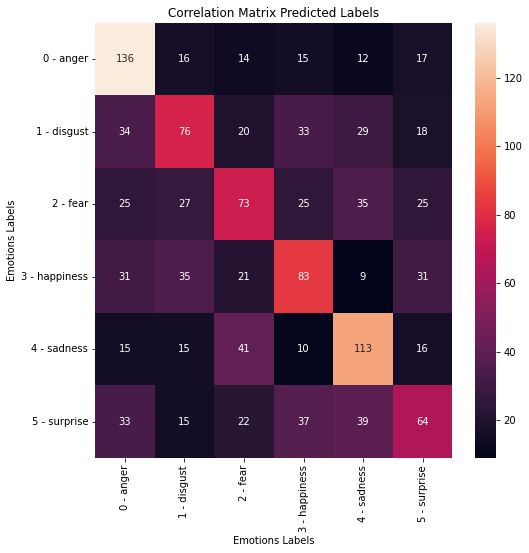

In [35]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), df[df.columns[4:]].values, labels)

## 1.1 - With high correlation elimination

accuracy:  0.43253968253968256
f1 score macro:  0.42589132351390524
f1 score micro:  0.43253968253968256
precision score:  0.42525367432849115
recall score:  0.4325396825396825
hamming_loss:  0.5674603174603174
matthews_corrcoef:  0.3199475430715964
zero_one_loss:  0.5674603174603174
               precision    recall  f1-score   support

    0 - anger       0.50      0.65      0.56       210
  1 - disgust       0.41      0.36      0.39       210
     2 - fear       0.38      0.35      0.36       210
3 - happiness       0.41      0.40      0.40       210
  4 - sadness       0.48      0.54      0.51       210
 5 - surprise       0.37      0.30      0.34       210

     accuracy                           0.43      1260
    macro avg       0.43      0.43      0.43      1260
 weighted avg       0.43      0.43      0.43      1260



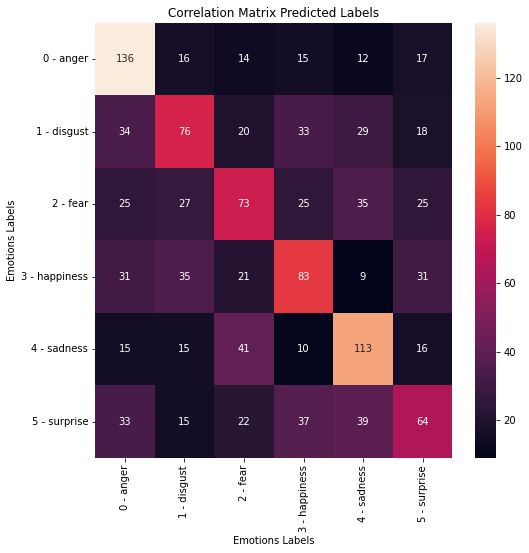

In [36]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, labels)

## 1.1.1 With All Principal Components

accuracy:  0.42142857142857143
f1 score macro:  0.4169047664330512
f1 score micro:  0.42142857142857143
precision score:  0.41919439900593075
recall score:  0.42142857142857143
hamming_loss:  0.5785714285714286
matthews_corrcoef:  0.30669225295349267
zero_one_loss:  0.5785714285714285
               precision    recall  f1-score   support

    0 - anger       0.47      0.60      0.53       210
  1 - disgust       0.40      0.35      0.38       210
     2 - fear       0.40      0.29      0.34       210
3 - happiness       0.36      0.40      0.38       210
  4 - sadness       0.50      0.50      0.50       210
 5 - surprise       0.39      0.38      0.38       210

     accuracy                           0.42      1260
    macro avg       0.42      0.42      0.42      1260
 weighted avg       0.42      0.42      0.42      1260



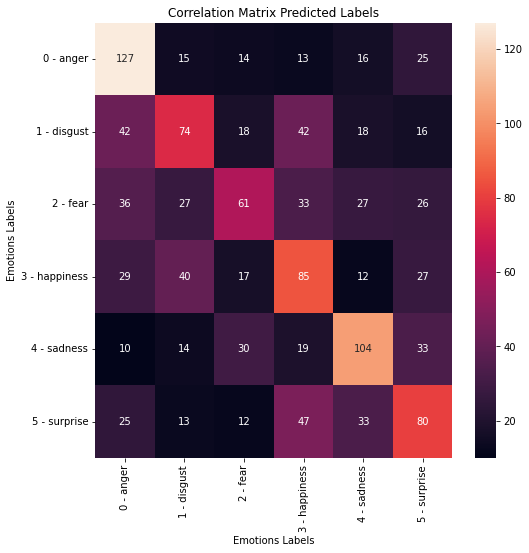

In [37]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca, labels)

## 1.1.2 - With an Ideal Number of Principal Components

accuracy:  0.4111111111111111
f1 score macro:  0.40727755386593006
f1 score micro:  0.4111111111111111
precision score:  0.4081963421699153
recall score:  0.41111111111111115
hamming_loss:  0.5888888888888889
matthews_corrcoef:  0.2939628166627123
zero_one_loss:  0.5888888888888889
               precision    recall  f1-score   support

    0 - anger       0.49      0.58      0.53       210
  1 - disgust       0.39      0.33      0.36       210
     2 - fear       0.41      0.30      0.35       210
3 - happiness       0.33      0.36      0.34       210
  4 - sadness       0.48      0.52      0.50       210
 5 - surprise       0.36      0.37      0.37       210

     accuracy                           0.41      1260
    macro avg       0.41      0.41      0.41      1260
 weighted avg       0.41      0.41      0.41      1260



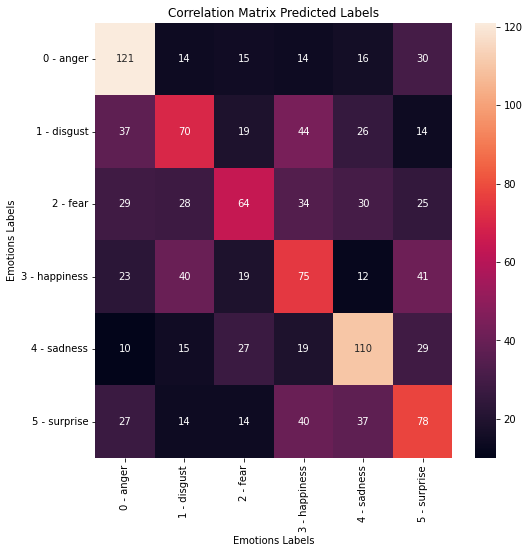

In [38]:
pca = PCA(n_components=num_component)
data_pca_ideal_comp = pca.fit_transform(data_scaled)
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_pca_ideal_comp, labels)

## 1.1.3 - With Feature Elimination with Backward Propagation

accuracy:  0.41904761904761906
f1 score macro:  0.41419243416238843
f1 score micro:  0.41904761904761906
precision score:  0.41668468327403224
recall score:  0.41904761904761906
hamming_loss:  0.580952380952381
matthews_corrcoef:  0.30393951418851
zero_one_loss:  0.5809523809523809
               precision    recall  f1-score   support

    0 - anger       0.45      0.59      0.51       210
  1 - disgust       0.43      0.37      0.40       210
     2 - fear       0.35      0.33      0.34       210
3 - happiness       0.45      0.38      0.41       210
  4 - sadness       0.44      0.52      0.48       210
 5 - surprise       0.38      0.32      0.35       210

     accuracy                           0.42      1260
    macro avg       0.42      0.42      0.41      1260
 weighted avg       0.42      0.42      0.41      1260



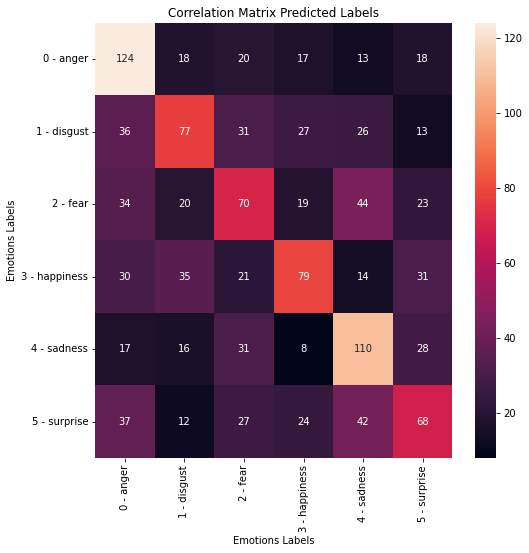

In [39]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data_elim_feats.values, labels)

## 1.1.3.1 - With All Principal Components

accuracy:  0.4158730158730159
f1 score macro:  0.41403512614602084
f1 score micro:  0.41587301587301584
precision score:  0.418187910110678
recall score:  0.4158730158730159
hamming_loss:  0.5841269841269842
matthews_corrcoef:  0.29985466367573593
zero_one_loss:  0.584126984126984
               precision    recall  f1-score   support

    0 - anger       0.42      0.49      0.45       210
  1 - disgust       0.50      0.39      0.43       210
     2 - fear       0.39      0.33      0.36       210
3 - happiness       0.38      0.43      0.40       210
  4 - sadness       0.43      0.50      0.46       210
 5 - surprise       0.39      0.35      0.37       210

     accuracy                           0.42      1260
    macro avg       0.42      0.42      0.41      1260
 weighted avg       0.42      0.42      0.41      1260



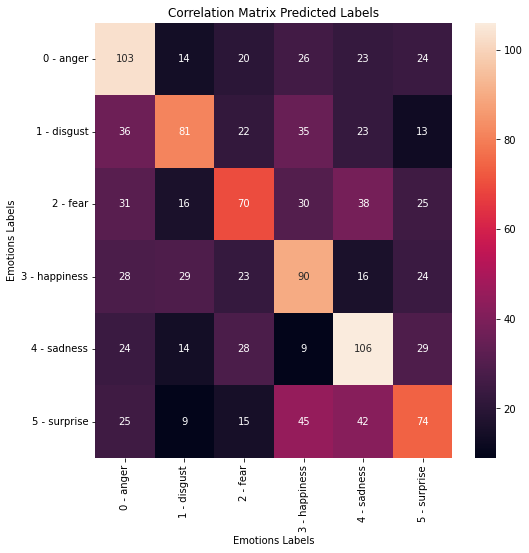

In [40]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim, labels
)

## 1.3.1.2 - With an Ideal Number of Principal Components

accuracy:  0.41984126984126985
f1 score macro:  0.41932466767435067
f1 score micro:  0.4198412698412699
precision score:  0.4211841180314264
recall score:  0.41984126984126985
hamming_loss:  0.5801587301587302
matthews_corrcoef:  0.30414327601182445
zero_one_loss:  0.5801587301587301
               precision    recall  f1-score   support

    0 - anger       0.43      0.47      0.45       210
  1 - disgust       0.49      0.42      0.45       210
     2 - fear       0.40      0.36      0.38       210
3 - happiness       0.38      0.41      0.39       210
  4 - sadness       0.42      0.48      0.45       210
 5 - surprise       0.41      0.38      0.39       210

     accuracy                           0.42      1260
    macro avg       0.42      0.42      0.42      1260
 weighted avg       0.42      0.42      0.42      1260



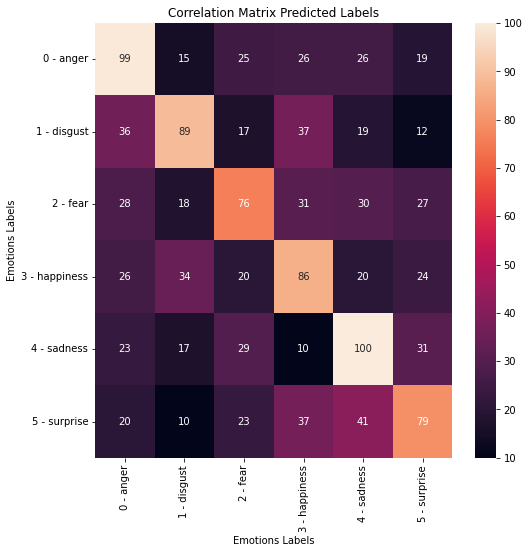

In [41]:
pca = PCA(n_components=num_component_elim)
data_pca_elim_ideal_comp = pca.fit_transform(data_scaled_elim)
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_pca_elim_ideal_comp, labels
)

## 1.3.1.2 - One vs Rest Classifier

accuracy:  0.4166666666666667
f1 score macro:  0.4129620851166646
f1 score micro:  0.4166666666666667
precision score:  0.4147623971713341
recall score:  0.4166666666666667
hamming_loss:  0.5833333333333334
matthews_corrcoef:  0.300810986432459
zero_one_loss:  0.5833333333333333
               precision    recall  f1-score   support

    0 - anger       0.45      0.55      0.50       210
  1 - disgust       0.44      0.42      0.43       210
     2 - fear       0.41      0.33      0.37       210
3 - happiness       0.40      0.38      0.39       210
  4 - sadness       0.40      0.49      0.44       210
 5 - surprise       0.38      0.32      0.35       210

     accuracy                           0.42      1260
    macro avg       0.41      0.42      0.41      1260
 weighted avg       0.41      0.42      0.41      1260



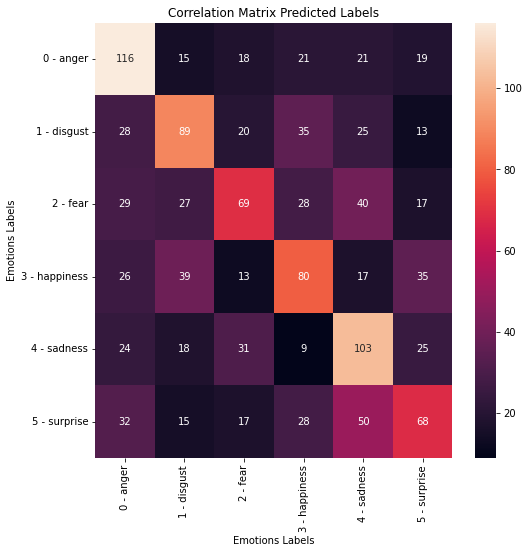

In [42]:
plot_cm_predictions(
    OneVsRestClassifier(RandomForest(random_state=1, max_features=None)),
    data_elim_feats.values, labels
)

## Valence and Arousal

In [43]:
display(HTML('<a href="https://www.researchgate.net/figure/Emotions-in-valence-arousal-space-13_fig3_329718637"><img src="https://www.researchgate.net/profile/Ananya-Bhattacharjee/publication/329718637/figure/fig3/AS:704946219532291@1545083684893/Emotions-in-valence-arousal-space-13.ppm" alt="Emotions in valence-arousal space [13]"/></a>'))

In [44]:
emotions = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}
emo_val = {
    'anger': 0,
    'disgust': 0,
    'fear': 0,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
emo_aro = {
    'anger': 1,
    'disgust': 1,
    'fear': 1,
    'happiness': 1,
    'sadness': 0,
    'surprise': 1
}
multi_pred = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 1): 2
}
labels_val = [emo_val[emotions[e]] for e in labels]
labels_aro = [emo_aro[emotions[e]] for e in labels]
labels_val_aro = [multi_pred[(emo_val[emotions[e]], emo_aro[emotions[e]])] for e in labels]

## Classification for valence only

accuracy:  0.6936507936507936
f1 score macro:  0.5949416847947392
f1 score micro:  0.6936507936507936
precision score:  0.6479159696420081
recall score:  0.5952380952380952
hamming_loss:  0.30634920634920637
matthews_corrcoef:  0.23737931842518023
zero_one_loss:  0.30634920634920637
                  precision    recall  f1-score   support

 0 - Low Valence       0.72      0.89      0.79       840
1 - High Valence       0.58      0.30      0.39       420

        accuracy                           0.69      1260
       macro avg       0.65      0.60      0.59      1260
    weighted avg       0.67      0.69      0.66      1260



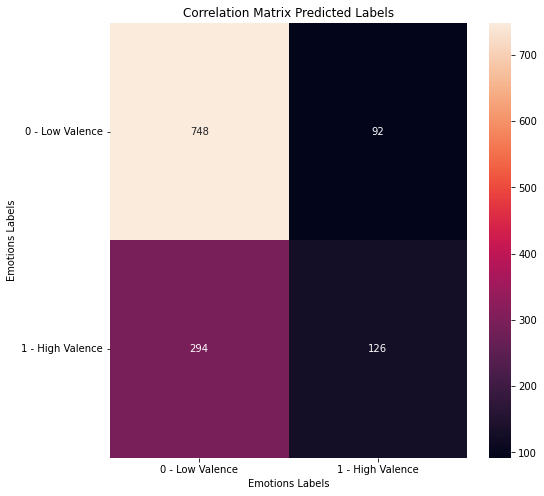

In [45]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val, val=True
)

## Classification for arousal only

accuracy:  0.8214285714285714
f1 score macro:  0.606708294085087
f1 score micro:  0.8214285714285714
precision score:  0.6492498840026808
recall score:  0.5919047619047619
hamming_loss:  0.17857142857142858
matthews_corrcoef:  0.23423727332412075
zero_one_loss:  0.1785714285714286
                  precision    recall  f1-score   support

 0 - Low Arousal       0.44      0.25      0.32       210
1 - High Arousal       0.86      0.94      0.90      1050

        accuracy                           0.82      1260
       macro avg       0.65      0.59      0.61      1260
    weighted avg       0.79      0.82      0.80      1260



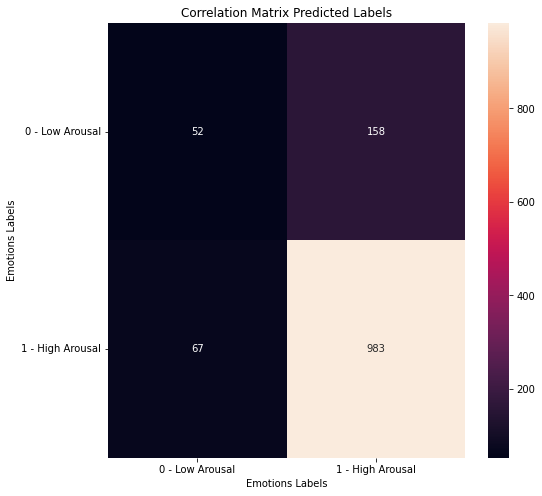

In [46]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_aro, aro=True
)

## Classification for valence and arousal

accuracy:  0.5753968253968254
f1 score macro:  0.5144170771756978
f1 score micro:  0.5753968253968254
precision score:  0.5489401858304297
recall score:  0.5058201058201058
hamming_loss:  0.4246031746031746
matthews_corrcoef:  0.27695585470349865
zero_one_loss:  0.42460317460317465
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.46      0.35      0.40       210
(0, 1) - anger, disgust, fear       0.59      0.77      0.67       630
 (1, 1) - happiness, surprise       0.59      0.40      0.47       420

                     accuracy                           0.58      1260
                    macro avg       0.55      0.51      0.51      1260
                 weighted avg       0.57      0.58      0.56      1260



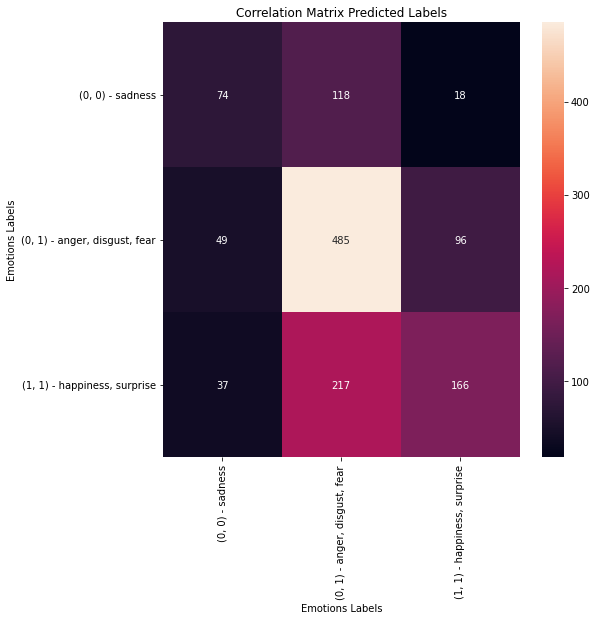

In [47]:
plot_cm_predictions(
    RandomForest(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Balanced Trees

accuracy:  0.5555555555555556
f1 score macro:  0.5414581250009772
f1 score micro:  0.5555555555555556
precision score:  0.5389847210268655
recall score:  0.5740740740740741
hamming_loss:  0.4444444444444444
matthews_corrcoef:  0.32111522678615634
zero_one_loss:  0.4444444444444444
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.38      0.66      0.48       210
(0, 1) - anger, disgust, fear       0.69      0.55      0.61       630
 (1, 1) - happiness, surprise       0.55      0.52      0.53       420

                     accuracy                           0.56      1260
                    macro avg       0.54      0.57      0.54      1260
                 weighted avg       0.59      0.56      0.56      1260



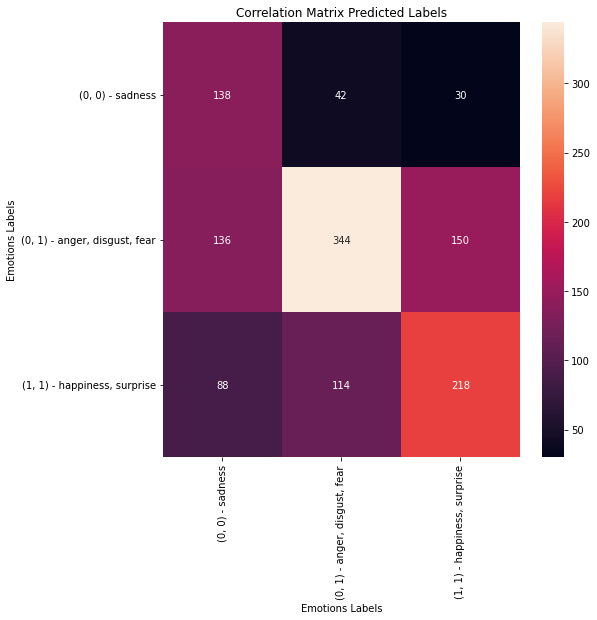

In [48]:
plot_cm_predictions(
    BalancedRandomForestClassifier(random_state=1, max_features=None),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5746031746031746
f1 score macro:  0.5515855719967311
f1 score micro:  0.5746031746031746
precision score:  0.547304503295714
recall score:  0.5706349206349207
hamming_loss:  0.4253968253968254
matthews_corrcoef:  0.3305216200742035
zero_one_loss:  0.42539682539682544
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.39      0.59      0.47       210
(0, 1) - anger, disgust, fear       0.67      0.61      0.64       630
 (1, 1) - happiness, surprise       0.57      0.52      0.54       420

                     accuracy                           0.57      1260
                    macro avg       0.55      0.57      0.55      1260
                 weighted avg       0.59      0.57      0.58      1260



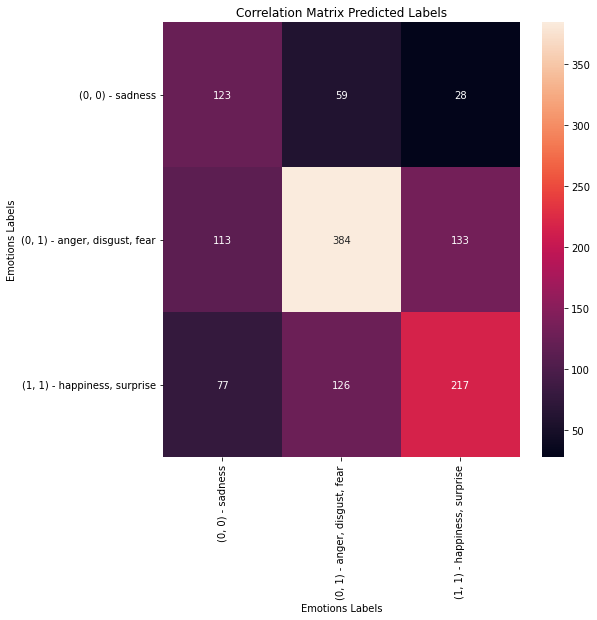

In [49]:
plot_cm_predictions(
    BalancedBaggingClassifier(
        RandomForest(random_state=1, max_features=None), 100, random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5595238095238095
f1 score macro:  0.5412163615122764
f1 score micro:  0.5595238095238095
precision score:  0.5392655090016235
recall score:  0.567989417989418
hamming_loss:  0.44047619047619047
matthews_corrcoef:  0.3217204813246349
zero_one_loss:  0.44047619047619047
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.37      0.61      0.46       210
(0, 1) - anger, disgust, fear       0.68      0.56      0.62       630
 (1, 1) - happiness, surprise       0.57      0.53      0.55       420

                     accuracy                           0.56      1260
                    macro avg       0.54      0.57      0.54      1260
                 weighted avg       0.59      0.56      0.57      1260



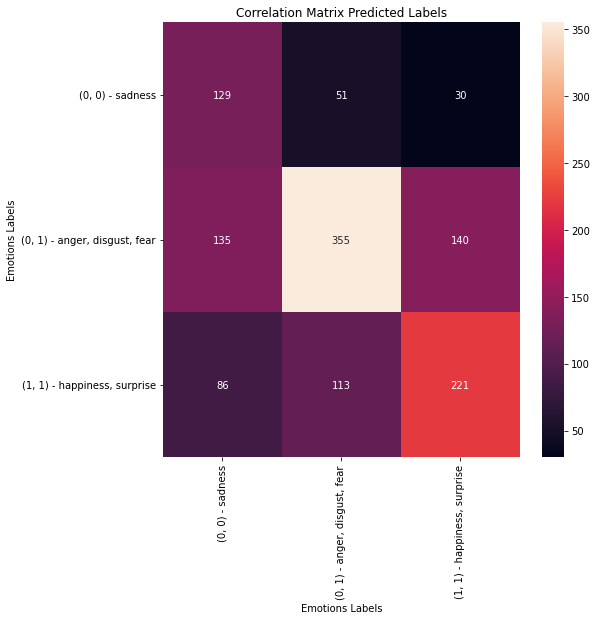

In [50]:
plot_cm_predictions(
    EasyEnsembleClassifier(
        100, RandomForest(random_state=1, max_features=None), random_state=1, n_jobs=8
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

accuracy:  0.5666666666666667
f1 score macro:  0.47774954205076564
f1 score micro:  0.5666666666666667
precision score:  0.5508804546602925
recall score:  0.4706349206349207
hamming_loss:  0.43333333333333335
matthews_corrcoef:  0.24634884150499933
zero_one_loss:  0.43333333333333335
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.50      0.25      0.34       210
(0, 1) - anger, disgust, fear       0.57      0.83      0.68       630
 (1, 1) - happiness, surprise       0.58      0.33      0.42       420

                     accuracy                           0.57      1260
                    macro avg       0.55      0.47      0.48      1260
                 weighted avg       0.56      0.57      0.53      1260



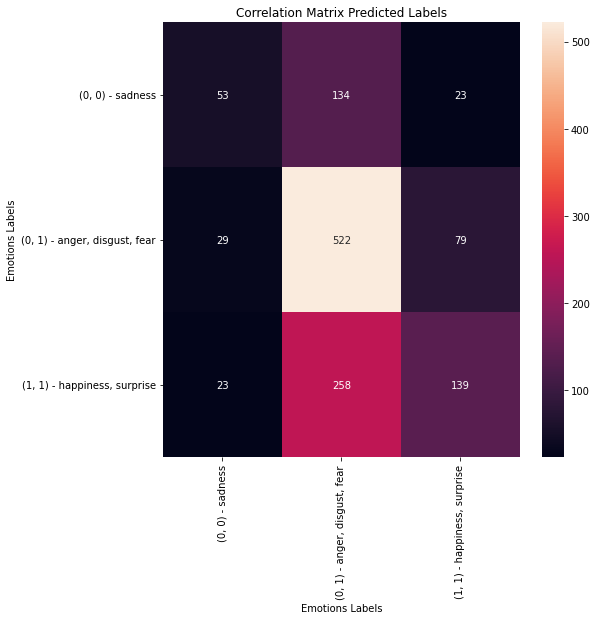

In [51]:
plot_cm_predictions(
    RUSBoostClassifier(
        RandomForest(random_state=1, max_features=None, n_jobs=8), n_estimators=100, random_state=1
    ),
    data_elim_feats.values, labels_val_aro, val=True, aro=True
)

## Simple Deep Learning

### Model

In [52]:
def build_model_0(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(64, 5, input_shape=input_shape))
    model.add(Activation('relu'))#2nd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))#3rd hidden layer
    model.add(Conv1D(64, 5, padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))#Add fully connected layer.
    model.add(GlobalAveragePooling1D())
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [53]:
build_model_0(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            384       
                                                                 
 activation (Activation)     (None, 10, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            20544     
                                                                 
 activation_1 (Activation)   (None, 10, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 64)            20544     
                                                                 
 activation_2 (Activation)   (None, 10, 64)            0         
                                                                 
 dropout (Dropout)           (None, 10, 64)            0

In [54]:
def build_model_1(input_shape=(12, 1)):
    model = Sequential()
    model.add(Conv1D(256, 5,padding='same', input_shape=input_shape)) #1
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #2
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 5,padding='same')) #3
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5,padding='same')) #6
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3)) #7
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [55]:
build_model_1(input_shape=(data_elim_feats.shape[1], 1)).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 14, 256)           1536      
                                                                 
 activation_4 (Activation)   (None, 14, 256)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 14, 128)           163968    
                                                                 
 activation_5 (Activation)   (None, 14, 128)           0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 128)           0         
 )                                                               
                                                      

### Compile and fit model

### Accuracy metric to evaluate performance, using adam optimizer, and categorical crossentropy as the loss function

In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

C:\Users\Chico\AppData\Local\Temp\ipykernel_7884\858656607.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_0, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5087301587301587
f1 score macro:  0.37934230549324893
f1 score micro:  0.5087301587301587
precision score:  0.45003672276938644
recall score:  0.3955026455026455
hamming_loss:  0.49126984126984125
matthews_corrcoef:  0.12329607018077184
zero_one_loss:  0.4912698412698413
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.32      0.16      0.21       210
(0, 1) - anger, disgust, fear       0.53      0.84      0.65       630
 (1, 1) - happiness, surprise       0.50      0.19      0.28       420

                     accuracy                           0.51      1260
                    macro avg       0.45      0.40      0.38      1260
                 weighted avg       0.48      0.51      0.45      1260



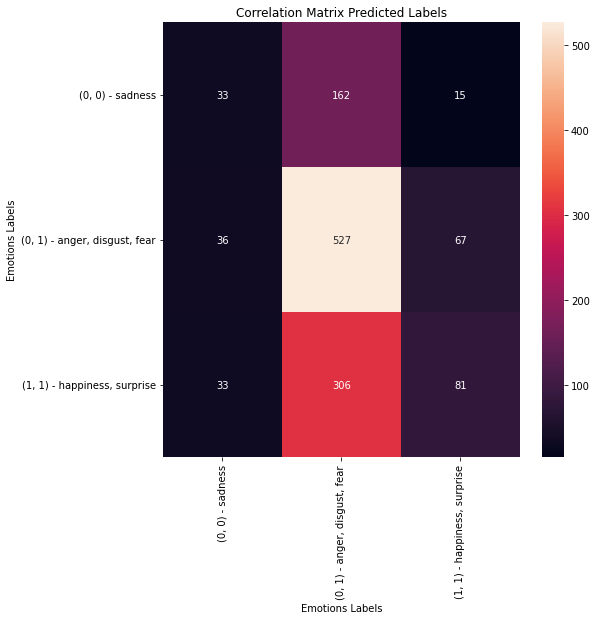

In [57]:
one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}
one_hot_labels_val_aro = [one_hot_encoding[i] for i in labels_val_aro]

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))

C:\Users\Chico\AppData\Local\Temp\ipykernel_7884\42186902.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])


accuracy:  0.5
f1 score macro:  0.2222222222222222
f1 score micro:  0.5
precision score:  0.16666666666666666
recall score:  0.3333333333333333
hamming_loss:  0.5
matthews_corrcoef:  0.0
zero_one_loss:  0.5
                               precision    recall  f1-score   support

             (0, 0) - sadness       0.00      0.00      0.00       210
(0, 1) - anger, disgust, fear       0.50      1.00      0.67       630
 (1, 1) - happiness, surprise       0.00      0.00      0.00       420

                     accuracy                           0.50      1260
                    macro avg       0.17      0.33      0.22      1260
                 weighted avg       0.25      0.50      0.33      1260



C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

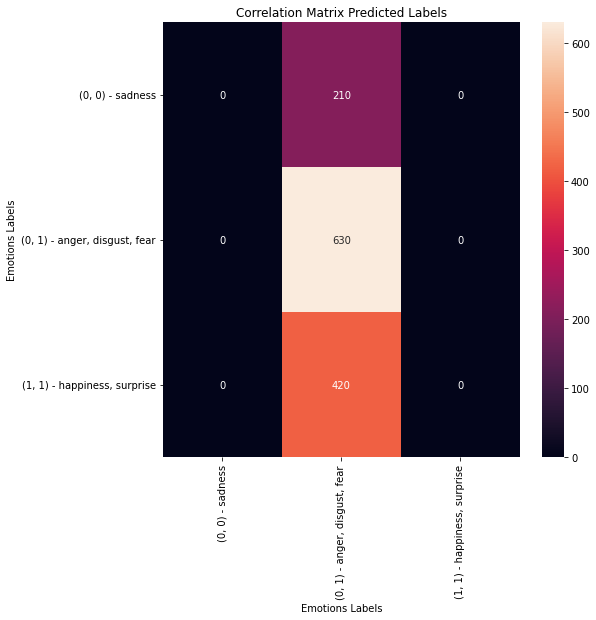

In [58]:
estimator = KerasRegressor(build_fn=build_model_1, input_shape=(data_elim_feats.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])

plot_cm_predictions(estimator, data_elim_feats, labels_val_aro, val=True, aro=True,
    one_hot_encoding=pd.DataFrame(one_hot_labels_val_aro))